## Instructions:
- You can use NN libraries such as tensorflow, pytorch, etc. But implement NF and importance sampling on your own.
- Zero tolerance for plagiarism. Do not copy from Practice and Share; the student who submitted there originally only can use; Github tracks who pushed what code.
- Total marks: 50 + 5 (bonus)
- Marks will be for plots and explanations. Describe your experiments, observations, challenges-faced, hyper-parameter tuning, etc., in the explanations.

In [ ]:
import CodingQuiz1 as given
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt
import torch
from torch import Tensor as tensor
import torch.nn as nn
import torch.nn.functional as function
import torch.optim as opt
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

# Q1: Model a 2D GMM using NF
- Prepare the target probability distribution $p_x^*$ as a GMM with 5 components
```
    ptarget = given.GMM()  
    samples = ptarget.sample(5) # to obtain 5 samples
    given.plot_samples_2d(samples, filename='target')   # plot the samples in file
    ptarget.prob(samples)       # to obtain probability values of samples
```
- Prepare the source distribution $p_u$ as a Gaussian with zero mean and unit variance. Use `given.Gaussian`.

## a.
- Given only the samples from the target distribution, train an NF $x=T(u)$ to model that distribution. Use any flow of your choice.
- Evaluation:
    - Generate samples from the model and plot them using `given.plot_samples_2d()`. Also plot samples from target distribution for comparison. Write your obervations in the markdown block below the plots. [10 marks]
    - Generate samples from the given target distribution and estimate their probabilities using the model as well as `ptarget.prob()`. Plot a histogram of the absolute difference in the two probability values. Write your obervations in the markdown block below the plots. [10 marks]

## b.
- Given only the function `ptarget.prob()` from the target distribution, train an NF to model that distribution.
- Evaluation:
    - Generate samples from the model and plot them using `given.plot_samples_2d()`. Also plot samples from target distribution for comparison. Write your obervations in the markdown block below the plots. [10 marks]
    - Generate samples from the given target distribution and estimate their probabilities using the model as well as `ptarget.prob()`. Plot a histogram of the absolute difference in the two probability values. Write your obervations in the markdown block below the plots. [10 marks]

## c. (BONUS)
- Draw plots that may help understand your models better. Write your obervations in the markdown block below the plots. [5 marks]

## YOUR CODE:

In [ ]:
ptarget = given.GMM()
pUu = given.Gaussian(mu = np.asarray([0.0 , 0.0]) , sigma = np.asarray([[1.0 , 0.0], [0.0, 1.0]]))

### Q1 a.

These classes are common for 1a and 1b as RNVP can be used to model both problems

In [ ]:
class neural_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(in_features = 1, out_features = 64)
        self.dense2 = nn.Linear(in_features = 64, out_features = 64)
        self.dense3 = nn.Linear(in_features = 64, out_features = 2)
        self.relu = nn.ReLU()
    def forward(self, u):
        u = self.relu(self.dense1(u))
        u = self.relu(self.dense2(u))
        u = torch.tanh(self.dense3(u))
        #return torch.exp(sig), mu*1.15
        return u

In [ ]:
class RNVP1a():
    def __init__(self, n, flip):
        self.length = n
        self.nns = [neural_net() for i in range(n)]
        self.flip = flip
    
    def revrse(self, x, batch_size):
        x1 = x[:, 0]
        x2 = x[:, 1]
        jacob = 0
        for i in range(self.length-1, -1, -1):
            if self.flip :
                x1, x2 = x2, x1
            x1 = x1.reshape((batch_size, -1))
            vals = self.nns[i](x1)
            s = torch.exp(vals[:,0])
            mu = vals[:,1]*1.15
            jacob += torch.log(s)
            
            x2 = x2 - mu
            x2 = x2 / s
            
            x1 = x1.reshape((batch_size))
            
        return torch.vstack((x1, x2)).T ,jacob
    
    def forwrd(self, u, batch_size):
        jacob = 0
        u1 = u[:, 0]
        u2 = u[:, 1]
        
        for i in range(self.length):
            u1 = u1.reshape((batch_size, -1))
            
            vals = self.nns[i](u1)
            s = torch.exp(vals[:,0])
            mu = vals[:,1]*1.15
            jacob += torch.log(s)
            
            u2 = u2*s + mu
            
            u1 = u1.reshape((batch_size))
            
            if self.flip:
                u1, u2 = u2, u1
        
        return torch.vstack((u1, u2)).T, jacob
        

In [ ]:
samples = ptarget.sample(100000) #samples only from target distribution 
np.random.shuffle(samples)

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26197 13125 15251 13541 31886]


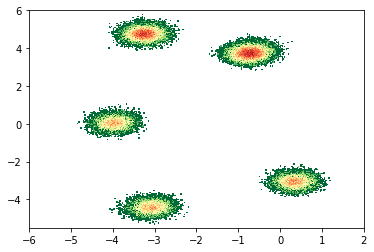

In [ ]:
begink = plt.hist2d(samples[:,0], samples[:,1], range = [[-6.0, 2.0], [-5.5 , 6.0]],bins = 500,cmap = "RdYlGn_r", norm = colors.LogNorm())
plt.show()
##################################################################
samples = tensor(samples)

In [ ]:
def dnormGaussian(x):
    num = -0.5*(x[:,0]**2 + x[:,1]**2)
    denom = 0.5/np.pi
    return denom*torch.exp(num)

In [ ]:
flow1a = RNVP1a(8, True)
parameter = []
for NN in flow1a.nns:
    parameter += list(NN.parameters())
optimizer = opt.Adagrad(params=parameter, lr=0.0005)

In [ ]:
ini_dis = MultivariateNormal(tensor([0.,0.]), tensor([[1.,0.],[0., 1.]]))
ini_dis.sample([10])
ini_s = ini_dis.sample([100000])

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26106 13246 15298 13591 31759]
tensor(1.9854) 499 0
tensor(1.6949) 999 0


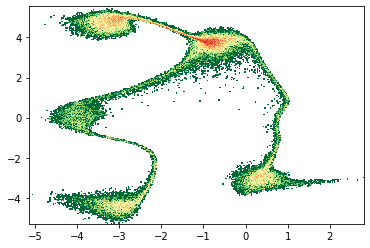

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26201 13275 15105 13594 31825]
tensor(1.7267) 499 1
tensor(1.9809) 999 1
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26091 13509 15176 13345 31879]
tensor(1.8851) 499 2
tensor(1.8472) 999 2
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26130 13291 15229 13597 31753]
tensor(1.8237) 499 3
tensor(1.8569) 999 3
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[25981 13446 15331 13581 31661]
tensor(2.0611) 499 4
tensor(1.8640) 999 4
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26198 13322 15188 13549 31743]
tensor(1.6808) 499 5
tensor(1.9277) 999 5


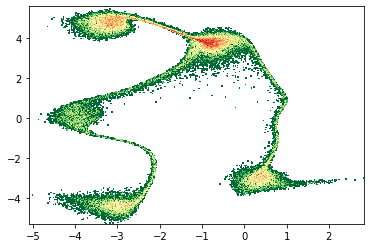

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26220 12881 15205 13680 32014]
tensor(1.7055) 499 6
tensor(1.8225) 999 6
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26109 13186 15224 13514 31967]
tensor(1.6900) 499 7
tensor(1.8691) 999 7
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26108 13106 15334 13486 31966]
tensor(1.9763) 499 8
tensor(1.8917) 999 8
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26089 13279 15329 13545 31758]
tensor(1.8666) 499 9
tensor(1.9679) 999 9
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26230 13442 14936 13493 31899]
tensor(1.7841) 499 10
tensor(1.9913) 999 10


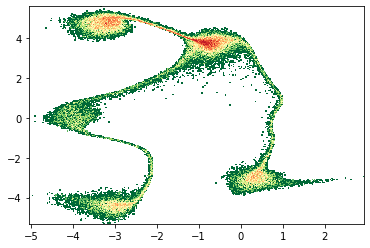

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26304 13086 15548 13269 31793]
tensor(1.8129) 499 11
tensor(1.9398) 999 11
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26039 13480 15140 13594 31747]
tensor(1.8031) 499 12
tensor(1.8400) 999 12
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26024 13291 15191 13579 31915]
tensor(1.8324) 499 13
tensor(1.6999) 999 13
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26296 13235 15083 13718 31668]
tensor(1.5088) 499 14
tensor(1.8357) 999 14
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26033 13217 15225 13813 31712]
tensor(1.8766) 499 15
tensor(1.8435) 999 15


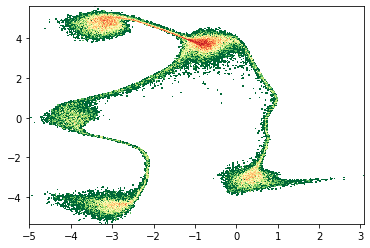

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26228 13301 15303 13506 31662]
tensor(1.8017) 499 16
tensor(1.7561) 999 16
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26092 13171 15145 13567 32025]
tensor(1.8028) 499 17
tensor(1.7957) 999 17
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26059 13324 15201 13504 31912]
tensor(1.7801) 499 18
tensor(1.8685) 999 18
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26204 13328 15035 13359 32074]
tensor(2.0344) 499 19
tensor(1.9746) 999 19
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26081 13180 15057 13463 32219]
tensor(1.8544) 499 20
tensor(1.6759) 999 20


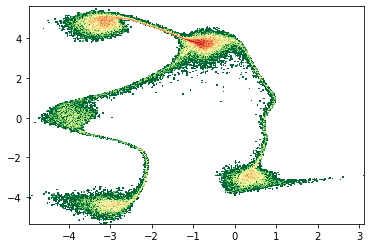

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26137 13046 15217 13496 32104]
tensor(2.0261) 499 21
tensor(1.6757) 999 21
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26067 13201 15202 13586 31944]
tensor(1.6196) 499 22
tensor(1.6234) 999 22
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26425 13178 15207 13416 31774]
tensor(1.9095) 499 23
tensor(1.7923) 999 23
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26408 13040 15147 13528 31877]
tensor(1.8250) 499 24
tensor(1.7549) 999 24
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26221 13093 15336 13387 31963]
tensor(1.6823) 499 25
tensor(1.6965) 999 25


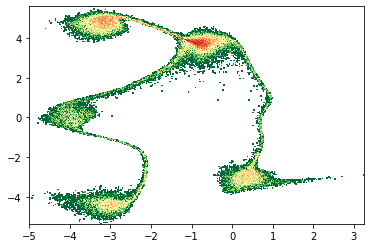

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26218 13273 15246 13647 31616]
tensor(1.8024) 499 26
tensor(1.7622) 999 26
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[25853 13391 15443 13493 31820]
tensor(1.7463) 499 27
tensor(1.9032) 999 27
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[25963 13175 15104 13520 32238]
tensor(1.8524) 499 28
tensor(1.8146) 999 28
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26259 13221 15331 13340 31849]
tensor(1.9106) 499 29
tensor(1.8605) 999 29
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26088 13154 15383 13563 31812]
tensor(1.7648) 499 30
tensor(1.7251) 999 30


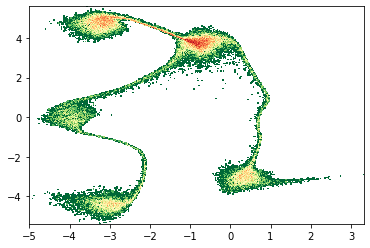

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[25996 13340 15086 13684 31894]
tensor(1.9226) 499 31
tensor(1.7843) 999 31
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[25962 13426 15037 13633 31942]
tensor(1.8316) 499 32
tensor(1.6966) 999 32
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26146 13228 15066 13676 31884]
tensor(1.8149) 499 33
tensor(1.7538) 999 33
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26072 13122 15100 13592 32114]
tensor(1.8630) 499 34
tensor(2.0315) 999 34
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26052 13286 15285 13688 31689]
tensor(1.8704) 499 35
tensor(2.0675) 999 35


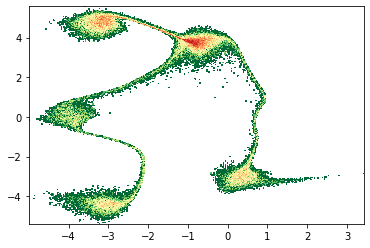

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26269 13193 15241 13473 31824]
tensor(1.6220) 499 36
tensor(1.7283) 999 36
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[25848 13283 15461 13540 31868]
tensor(1.8903) 499 37
tensor(1.8605) 999 37
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[25846 13518 15380 13465 31791]
tensor(1.6136) 499 38
tensor(1.6847) 999 38
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26143 13371 15085 13442 31959]
tensor(1.7317) 499 39
tensor(1.5992) 999 39
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26254 13095 15249 13542 31860]
tensor(1.8931) 499 40
tensor(1.7380) 999 40


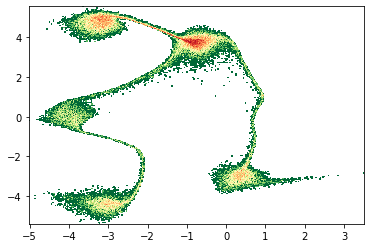

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26372 13220 15191 13555 31662]
tensor(1.8188) 499 41
tensor(1.7269) 999 41
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26434 13287 15224 13336 31719]
tensor(1.7097) 499 42
tensor(1.8013) 999 42
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26124 13173 15276 13586 31841]
tensor(1.7572) 499 43
tensor(1.5840) 999 43
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26059 13169 15261 13547 31964]
tensor(1.7190) 499 44
tensor(1.7261) 999 44
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26103 13312 15279 13519 31787]
tensor(1.8449) 499 45
tensor(1.6626) 999 45


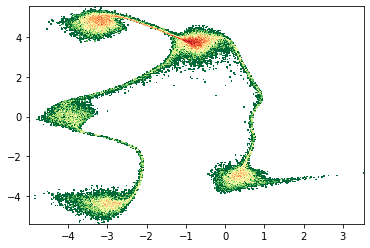

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26347 13288 15381 13423 31561]
tensor(1.5822) 499 46
tensor(1.9880) 999 46
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[25845 13160 15273 13599 32123]
tensor(1.6520) 499 47
tensor(1.6590) 999 47
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26060 13437 15336 13520 31647]
tensor(1.7850) 499 48
tensor(1.6389) 999 48
[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[26058 13153 15487 13603 31699]
tensor(1.6422) 499 49
tensor(1.5813) 999 49


In [ ]:
epochs = 50 #### training
batch_size = 100
num_batch = 100000//batch_size
for ep in range(epochs):
    samples = ptarget.sample(100000)
    np.random.shuffle(samples)
    samples = tensor(samples)
    for j in range(num_batch):
        x = samples[j*batch_size:(j+1)*batch_size]
        u, jacob = flow1a.revrse(x, batch_size)
        ufoo = torch.log(dnormGaussian(u) + 1e-30) ##adding tolerance values for restricting NaN values for very small 
        loss = (- ufoo.sum() + jacob.sum())/batch_size
        if j%500 == 499:
            print(loss.data, j, ep)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if ep%5 == 0:
        samples = flow1a.forwrd(ini_s, 100000)
        plt.hist2d(samples[0].detach().numpy()[:,0], samples[0].detach().numpy()[:,1], bins = 500, cmap = "RdYlGn_r", norm = colors.LogNorm())
        plt.show()

#### Samples plot for 1a

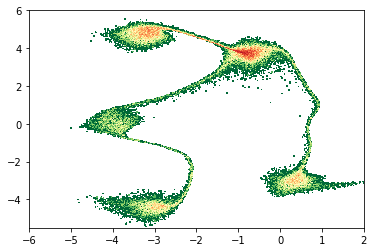

In [ ]:
s = flow1a.forwrd(ini_s, 100000)
k = plt.hist2d(s[0].detach().numpy()[:,0], s[0].detach().numpy()[:,1], bins = 500,range = [[-6.0, 2.0], [-5.5 , 6.0]],cmap = "RdYlGn_r", norm = colors.LogNorm())
plt.show()

In [ ]:
for i in range(8):####saving model
    torch.save(flow1a.nns[i].state_dict(), 'finalmod1n{}.pt'.format(i))

In [ ]:
myarray = abs(k[0] - begink[0])

###this array contains difference of probabilities


histogram of absolute probability difference between original and transformed values

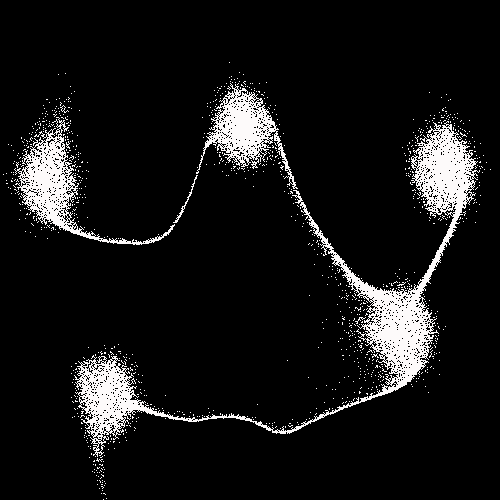

In [ ]:
from PIL import Image
from matplotlib import cm
Image.fromarray(np.uint8(cm.gist_earth(myarray)*255))

## 1b code starts

In [ ]:
##### Q1 b. #####
flow1b = RNVP1a(8, True)
parameter = []
for NN in flow1b.nns:
    parameter += list(NN.parameters())
optimizer = opt.Adagrad(params=parameter, lr=0.0005)

In [ ]:
GMM_weights = tensor(ptarget.weights)
GMM_mus = tensor([ptarget.components[i].mu for i in range(5)])
GMM_sigma = tensor([ptarget.components[i].sigma for i in range(5)])
GMM_sigmainv = tensor([ptarget.components[i].sigmainv for i in range(5)])
GMM_Z = [tensor([ptarget.components[i].Z]) for i in range(5)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [ ]:
def dGaussian(x_s, mu, sigmainv, Z):
  x_s = x_s - mu
  return torch.exp(-0.5*(x_s@sigmainv*x_s).sum(1))/Z
    
def dGMM(x_s, weights,mu,sigma, sigmainv, Z):
  p = []
  for i in range(5):
    p.append(dGaussian(x_s, mu[i], sigmainv[i], Z[i]))
  p = (torch.vstack(p).T * weights).sum(1)
  return p

tensor(-1.6315) 499 0
tensor(-1.3081) 999 0


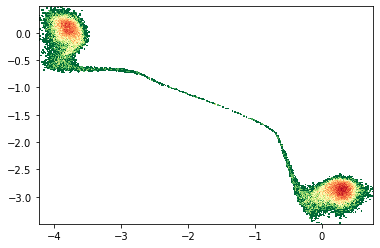

tensor(-0.9309) 499 1
tensor(-1.2598) 999 1
tensor(-1.0353) 499 2
tensor(-0.5638) 999 2
tensor(-1.0550) 499 3
tensor(-1.6826) 999 3
tensor(-0.3821) 499 4
tensor(-0.8405) 999 4
tensor(-0.6098) 499 5
tensor(-0.6025) 999 5


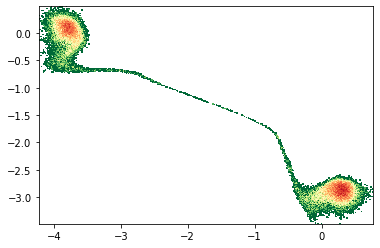

tensor(-0.6319) 499 6
tensor(-0.9506) 999 6
tensor(-0.6543) 499 7
tensor(-1.2828) 999 7
tensor(-1.0296) 499 8
tensor(-0.5646) 999 8
tensor(-1.7013) 499 9
tensor(-0.7477) 999 9
tensor(-1.6672) 499 10
tensor(-1.1846) 999 10


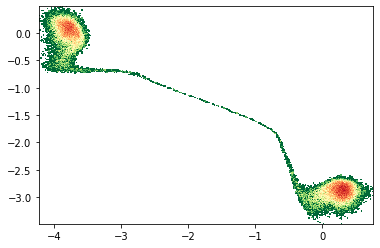

tensor(-1.1182) 499 11
tensor(-0.4675) 999 11
tensor(-1.5460) 499 12
tensor(-1.2264) 999 12
tensor(-1.5249) 499 13
tensor(-0.8531) 999 13
tensor(-0.9582) 499 14
tensor(-0.1236) 999 14
tensor(-0.6643) 499 15
tensor(-1.5113) 999 15


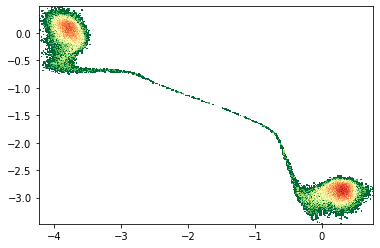

tensor(-1.3794) 499 16
tensor(-0.5614) 999 16
tensor(-0.5032) 499 17
tensor(-1.0529) 999 17
tensor(-1.2183) 499 18
tensor(-1.0264) 999 18
tensor(-1.8690) 499 19
tensor(-1.4515) 999 19
tensor(-0.7036) 499 20
tensor(-1.0248) 999 20


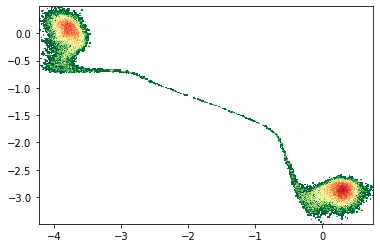

tensor(-0.9656) 499 21
tensor(-0.2686) 999 21
tensor(-0.8748) 499 22
tensor(-0.6856) 999 22
tensor(-1.5014) 499 23
tensor(-0.9091) 999 23
tensor(-0.2913) 499 24
tensor(-0.5956) 999 24
tensor(-1.0349) 499 25
tensor(-1.5467) 999 25


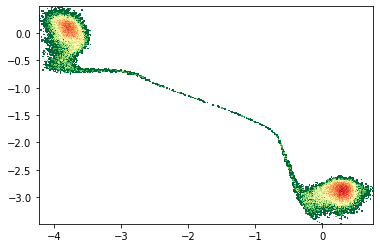

tensor(-0.7151) 499 26
tensor(-0.7597) 999 26
tensor(-1.0072) 499 27
tensor(-1.3089) 999 27
tensor(-0.8911) 499 28
tensor(-1.1601) 999 28
tensor(-0.5267) 499 29
tensor(-1.3364) 999 29
tensor(-1.0960) 499 30
tensor(-1.0015) 999 30


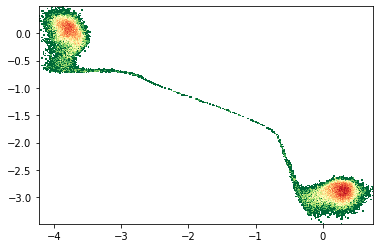

tensor(-1.0601) 499 31
tensor(-0.1512) 999 31
tensor(-0.6649) 499 32
tensor(-1.0416) 999 32
tensor(-1.2208) 499 33
tensor(-1.3040) 999 33
tensor(-0.8942) 499 34
tensor(-0.5693) 999 34
tensor(-0.6289) 499 35
tensor(-0.1082) 999 35


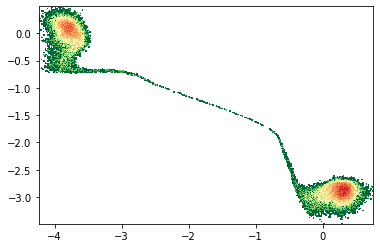

tensor(-1.4562) 499 36
tensor(-1.2669) 999 36
tensor(-0.7626) 499 37
tensor(-0.7471) 999 37
tensor(-1.1221) 499 38
tensor(-1.1535) 999 38
tensor(-0.7274) 499 39
tensor(-1.0274) 999 39
tensor(-0.8774) 499 40
tensor(-0.1534) 999 40


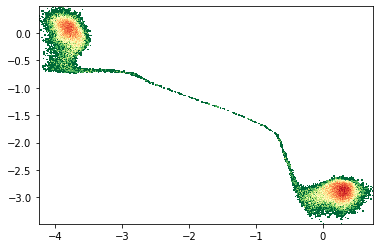

tensor(-0.8653) 499 41
tensor(-1.2007) 999 41
tensor(-1.1001) 499 42
tensor(-1.2553) 999 42
tensor(-0.6797) 499 43
tensor(-1.0823) 999 43
tensor(-0.3952) 499 44
tensor(-0.0932) 999 44
tensor(-1.6522) 499 45
tensor(-0.1518) 999 45


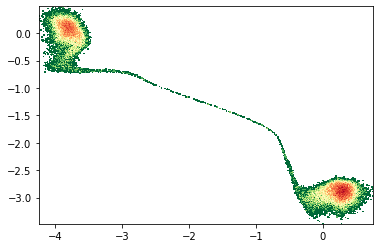

tensor(-1.1671) 499 46
tensor(-0.4477) 999 46
tensor(-0.4394) 499 47
tensor(-1.2791) 999 47
tensor(-1.0613) 499 48
tensor(-1.2185) 999 48
tensor(-1.2343) 499 49
tensor(-2.0846) 999 49


In [ ]:
pUu2 = given.Gaussian(mu = np.asarray([0.0 , 0.0]) , sigma = np.asarray([[5.0 , 0.0], [0.0, 5.0]]))
epochs = 50 #### training
batch_size = 100
num_batch = 100000//batch_size
for ep in range(epochs):
    samples = pUu2.sample(100000)
    np.random.shuffle(samples)
    samples = tensor(samples)
    for j in range(num_batch):
        x = samples[j*batch_size:(j+1)*batch_size]
        u, jacob = flow1b.forwrd(x, batch_size)
        x = torch.log(dnormGaussian(x) + 1e-30)
        ufoo = torch.log(dGMM(u, GMM_weights, GMM_mus, GMM_sigma, GMM_sigmainv, GMM_Z) + 1e-30) ##adding tolerance values for restricting NaN values for very small 
        loss = (- ufoo.sum() + x.sum() - jacob.sum())/batch_size
        if j%500 == 499:
            print(loss.data, j, ep)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if ep%5 == 0:
        samples = flow1b.forwrd(ini_s, 100000)
        plt.hist2d(samples[0].detach().numpy()[:,0], samples[0].detach().numpy()[:,1], bins = 500, cmap = "RdYlGn_r", norm = colors.LogNorm())
        plt.show()

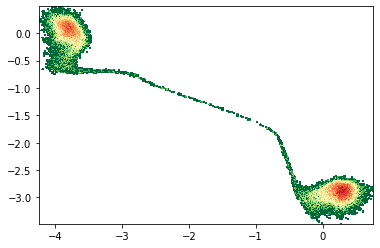

In [ ]:
s = flow1b.forwrd(ini_s, 100000)
k = plt.hist2d(s[0].detach().numpy()[:,0], s[0].detach().numpy()[:,1], bins = 500, range = [[-6.0, 2.0], [-5.5 , 6.0]],cmap = "RdYlGn_r", norm = colors.LogNorm())
plt.hist2d(s[0].detach().numpy()[:,0], s[0].detach().numpy()[:,1], bins = 500,cmap = "RdYlGn_r", norm = colors.LogNorm())
plt.show()

Histogram of absolute prob diff for 1b

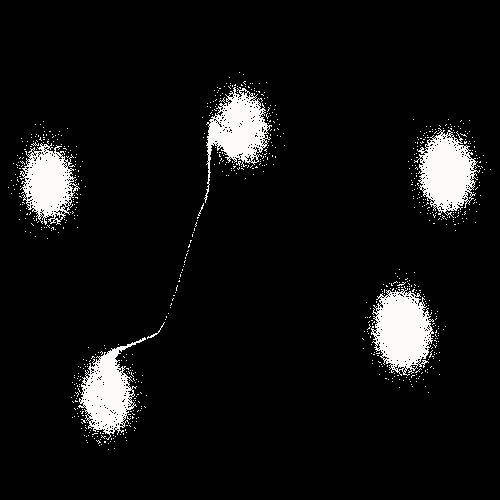

In [ ]:
myarray = abs(k[0] - begink[0])
###this array contains difference of probabilities

Image.fromarray(np.uint8(cm.gist_earth(myarray)*255)) 

In [ ]:
##### Q1 c. #####

NONE

## YOUR OBSERVATIONS:

### Q1 a.
Hyperparameter - value of bias $\mu$ used in lecture tuned to `1.15` after using various values.
Using template provided by pytorch by defining `neural_net` class akin to defined in RNVP implementation in class. 
Training plots clearly show convergence at places where the original data was dense.
Histograms for both 1a and 1b are plotted using IMG library for 2d rendering. 
### Q1 b.
Since RNVP can be trained both ways, a different model is used in 1b named flow1b but having the same architecture. It used a different loss function and can be seen to converge on values. Hyperparameter tuning took a lot of time and efforts. Used Cross- Validation for getting to values.

1b or the RNVP only captures samples from two of the clusters here. The reasons for the above behaviour is outlined below.

1a training or training using samples was way better than using $p^*(x)$ for reasons of loss function. Reverse-KL divergence multiplies the ratio by value of q(x) which is quiet low for regions not in p(x). thus loss function penalises less for outliers but dies quickly.
### Q1 c.


# Q2: Importance Sampling
Use the codes and models of Q1 to solve this problem
1. Assume you do not have access to `ptarget.sample()` but only to `ptarget.prob()`. Estimate $E[x^2]$ using the NF models of Q1a and Q1b. Write your obervations in the markdown block below the plots. [5 marks]
2. Evaluation: Now using the complete class `ptarget`, find $E[x^2]$ and compare it with the value computed in Q2.1. Write your obervations in the markdown block below the plots. [5 marks]

## YOUR CODE:

In [ ]:
##### Q2.1 #####
n = 10000
pUsamples = tensor(pUu.sample(S = n))
pX_trans_samples1a,_ = flow1a.forwrd(pUsamples,n)
Ex2_NF1a = [(pX_trans_samples1a[:,0]**2).sum()/n , (pX_trans_samples1a[:,1]**2).sum()/n]

pUsamples = tensor(pUu.sample(S = n))
pX_trans_samples1b,_ = flow1b.forwrd(pUsamples,n)
Ex2_NF1b = [(pX_trans_samples1b[:,0]**2).sum()/n , (pX_trans_samples1b[:,1]**2).sum()/n]

In [ ]:
##### Q2.2 #####

samples = ptarget.sample(n)
Ex2direct = [(samples[:,0]**2).sum()/n , (samples[:,1]**2).sum()/n]

[0.26164062 0.13245135 0.15262771 0.13528791 0.31799242]
[2665 1246 1479 1317 3293]


In [ ]:
print("E[x^2] using direct samples from ptarget is :", Ex2direct)
print("E[x^2] using transformed samples from Q1a NF is :", Ex2_NF1a)
print("E[x^2] using transformed samples from Q1a NF is :", Ex2_NF1b)

E[x^2] using direct samples from ptarget is : [6.226281579373005, 14.702151113045367]
E[x^2] using transformed samples from Q1a NF is : [tensor(5.2280, grad_fn=<DivBackward0>), tensor(14.9326, grad_fn=<DivBackward0>)]
E[x^2] using transformed samples from Q1a NF is : [tensor(6.3373, grad_fn=<DivBackward0>), tensor(4.7705, grad_fn=<DivBackward0>)]


## YOUR OBSERVATIONS:

### Q2.1
Since I have access to only `ptarget.prob()` I use the model that I trained in Part 1b using only `ptarget.prob()`. Then I sample `n` samples from given `pUu` and transformed it using Normalizing Flow to get target samples from `ptarget`. Then $E[x^2]$ is calculated using Monte-Carlo Approximation.
$$ E_{p^*(x)}[x^2] = \frac{\sum_{y_i}(y^2)}{n} ; y_i \: from \: p^*(x)$$

Even though the model is well trained, the flow was not able to calculate $E[x^2]$ with much accuracy, although the histogram is very close to original pdf.

### Q2.2

Direct samples from `ptarget` used for Monte-Carlo Approximation, 10000 original samples from target means the estimate is very close to original value of x^2.
